In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from iminuit import Minuit
import calendar
import json
from scipy import linalg

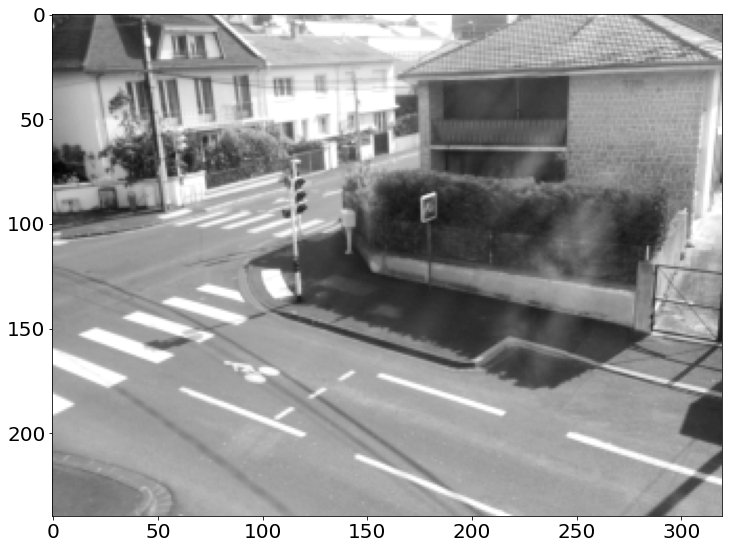

In [149]:
###### with open('/home/theo/Documents/python/Pi/input/2021-03-25/picture_506.npy', 'rb') as f:
with open('/home/theo/Documents/python/Pi/input/2021-04-19/picture_0.npy', 'rb') as f:
    data = np.load(f)
plt.imshow(data, cmap=plt.get_cmap('gray'))

In [2]:
def getImages(input_dir):
    pic_list = []
    
    pic_name_list = glob.glob(f'{input_dir}/picture_*.npy')
    for i in range(len(pic_name_list)):
        try:
            with open(f'{input_dir}/picture_{i}.npy', 'rb') as f:
                p_arr = np.load(f)
                pic_list.append( p_arr.reshape(1, p_arr.shape[0], p_arr.shape[1], 1) )
        except:
            print(f'{input_dir}/picture_{i}.npy not found!')

    data = np.concatenate(pic_list, axis=0)
    data = data / 255 # normalise    
    return data


def getLabels(input_dir):
    with open(f'{input_dir}/labels.npy', 'rb') as f:      
        labels = np.load(f).astype(int)
    return labels


def predictLabels(nn, data):
    predictions = nn.predict(data)
    pred_labels = np.argmax(predictions, axis=1)
    return pred_labels

The data follows a **multinomial** probability density function:

$\boldsymbol{\mathbf{\mathcal{L} = \frac{N!}{\prod_{i=0}^{2}n_i!} \cdot \prod_{i=0}^{2} p_i^{n_i}}}$ with $N = \sum_{i=0}^{2} n_i$  

The event numbers $n_i$ are the event numbers we measure with the convolutional neural network, and the $p_i$ are the corresponding probabilities (apparent).  
The parameters we want to infer are the "true" probabilities, i.e. corrected for the inaccuracies of the CNN.

The true ($n_j^t$) and the apparent ($n_i$) event numbers are related by the confusion matrix ($c_{ij}$) as:  
$ (n_0, n_1, n_2) = (n_0^t, n_1^t, n_2^t) \cdot
\begin{bmatrix} 
c_{00} & c_{01} & c_{02} \\
c_{10} & c_{11} & c_{12} \\
c_{20} & c_{21} & c_{22} \\
\end{bmatrix}
\quad
$

It follows that the apparent probabilities ($p_i$) can be expressed as a function of the true probabilities ($p_i^t$): 
$p_i = c_{0i}\cdot p_0^t + c_{1i}\cdot p_1^t + c_{2i}\cdot p_2^t$

The likelihood is re-parametrised in order to measure the infraction ration $r$ directly:  
$r = \frac{p_2^t}{p_1^t+p_2^t} \Leftrightarrow p_1^t = \frac{p_2^t(1-r)}{r}$  

Moreover, the number of free parametres is reduced to 2 (from 3) thanks to the relation:  
$\sum_{i=0}^{2} p_i^t = 1 \Leftrightarrow p_0^t = 1-p_2^t/r$


In [3]:
def sumn(n):
    return np.sum( np.log(np.arange(n)+1) )


def fold(i, conf_matrix):
    # get reco-level probability as a function of truth-level probabilities using confusion matrix
    folded_prob = lambda r,p2 : ( conf_matrix[0,i]*(1-p2/r)
                                + conf_matrix[1,i]*p2*(1-r)/r
                                + conf_matrix[2,i]*p2
                                )
    return folded_prob


def multinomial(n_raw, conf_matrix):
    # compute log-likelihood
    factorial_term = sumn(np.sum(n)) - sumn(n[0]) - sumn(n[1]) - sumn(n[2])
    nll = lambda r,p2 : -( factorial_term
                         + n[0]*np.log( fold(0,conf_matrix)(r,p2) )
                         + n[1]*np.log( fold(1,conf_matrix)(r,p2) )
                         + n[2]*np.log( fold(2,conf_matrix)(r,p2) )
                         )
    return nll

In [4]:
def getSystematicVariation(n_raw, cm_nom, cm_up, cm_down):
    # get nominal truth
    truth_nom = linalg.solve(conf_matrix_nom.T, n_raw)
    
    # fold nominal truth with systematic confusion matrices
    n_up = (truth_nom @ conf_matrix_lumi_up - n_raw) / n_raw
    n_down = (truth_nom @ conf_matrix_lumi_down - n_raw) / n_raw
    
    # symmetrise by keeping largest absolute value
    n_sys = np.where(np.abs(n_up) > np.abs(n_down), n_up, -n_down)
    
    return n_sys

## Import trained CNN and confusion matrix

In [5]:
import keras.models
cnn = keras.models.load_model('CNN.h5')

Using TensorFlow backend.
/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/theo/anacon

/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/theo/anaconda3/e

In [6]:
with open('confusion_matrix.json', 'r') as f:
    conf_matrix = json.load(f)
    
conf_matrix_nom = np.array(conf_matrix['nominal'])
conf_matrix_lumi_up = np.array(conf_matrix['lumi_up'])
conf_matrix_lumi_down = np.array(conf_matrix['lumi_down'])

## Apply CNN to data

In [7]:
input_dir = ['input/2021-03-08', 'input/2021-03-09', 'input/2021-03-17', 'input/2021-03-18',
             'input/2021-03-19', 'input/2021-03-20', 'input/2021-03-21', 'input/2021-03-22',
             'input/2021-03-24', 'input/2021-03-25', 'input/2021-03-26', 'input/2021-03-27',
             'input/2021-03-29', 'input/2021-03-30', 'input/2021-03-31', 'input/2021-04-01',
             'input/2021-04-02', 'input/2021-04-03', 'input/2021-04-04', 'input/2021-04-15',
             'input/2021-04-16', 'input/2021-04-17', 'input/2021-04-18', 'input/2021-04-19',
             'input/2021-04-20']

In [10]:
input_dir = glob.glob('input/2021*')

In [8]:
pred_labels = []
counts_list = []

rerun = False

for indir in input_dir:
    label_path = f'{indir}/pred_labels.npy'
    if not os.path.isfile(label_path) or rerun:
        print(indir)
        data = getImages(indir)
        pred = predictLabels(cnn, data)
        with open(label_path, 'wb') as f:
            np.save(f, pred)
            
    else:
        with open(label_path, 'rb') as f:
            pred = np.load(f)
    pred_labels.append(pred)
    counts = np.unique(pred, return_counts=True)[1]
    counts_list.append(counts)

In [9]:
counts_list = np.array(counts_list)
infraction_ratio = counts_list[:,2] / (counts_list[:,2]+counts_list[:,1])

In [10]:
df_full = pd.DataFrame({'date':[i.replace('input/','') for i in input_dir], 'nocar':counts_list[:,0],
                   'respect':counts_list[:,1], 'infraction':counts_list[:,2]})

df_full['date'] = df_full['date'].astype('datetime64')
df_full.sort_values(by='date', inplace=True)
df_weekday = df_full.copy()

## Overall infraction ratio

In [11]:
n = df_full.sum().to_numpy()
lumi_sys = getSystematicVariation(n, conf_matrix_nom, conf_matrix_lumi_up, conf_matrix_lumi_down)

m = Minuit(multinomial(n, conf_matrix_nom), p2=n[2]/np.sum(n), r=n[2]/np.sum(n[1:]))
m.errordef = 0.5
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.392                      │              Nfcn = 36               │
│ EDM = 1.12e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ r    │   0.429   │   0.009   │            │            │         │         │       │
│ 1 │ p2   │  0.1472   │  0.0034   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        r       p2 │
├────┼───────────────────┤
│  r │ 7.27e-05 2.51e-05 │
│ p2 │ 2.51e-05 1.19e-05 │
└────┴───────────────────┘

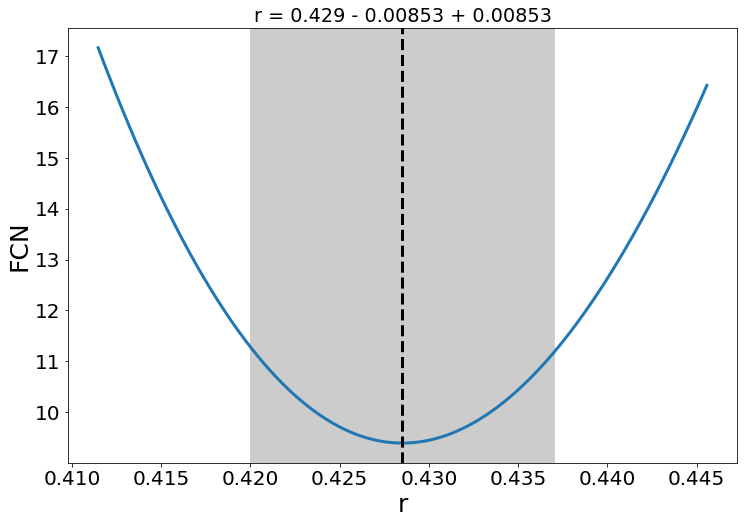

In [12]:
plt.figure(figsize=(12,8))
m.draw_profile("r");

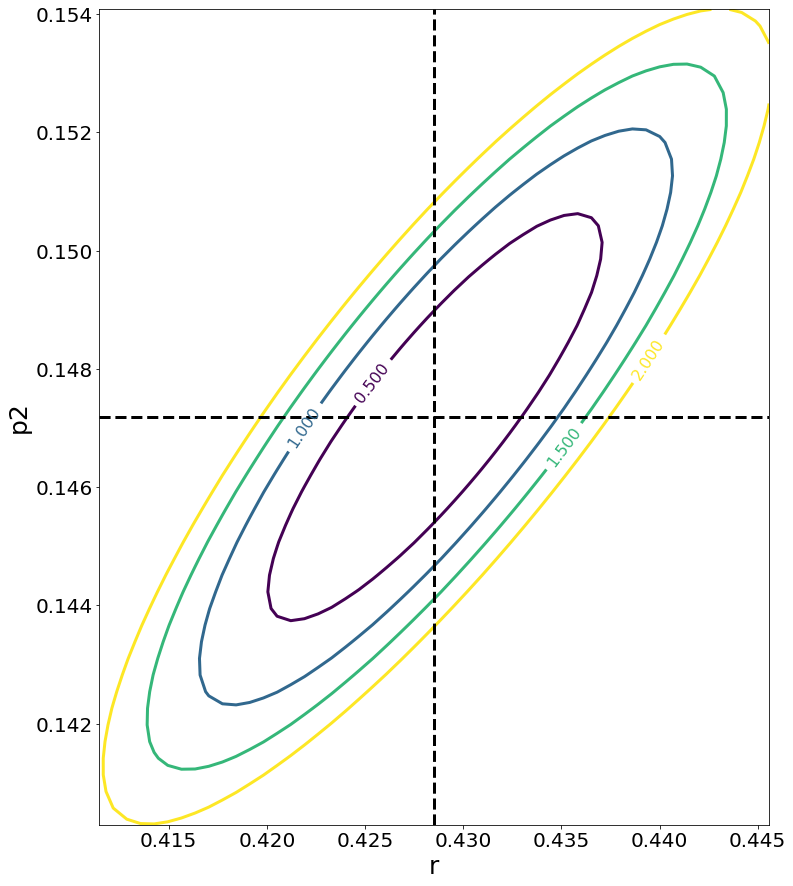

In [13]:
m.draw_contour('r','p2');

## Infraction ratio as a function of time

In [14]:
best_fit = []
error = []

for i in range(df_full.shape[0]):
    n = df_full.iloc[i,1:].to_numpy().astype(np.int32)
    m = Minuit(multinomial(n, conf_matrix_nom), p2=n[2]/np.sum(n), r=n[2]/np.sum(n[1:]))
    m.errordef = 0.5
    m.migrad()
    best_fit.append( m.values['r'] )
    error.append( m.errors['r'] )
    
df_full['best_fit_ratio'] = best_fit
df_full['error'] = error

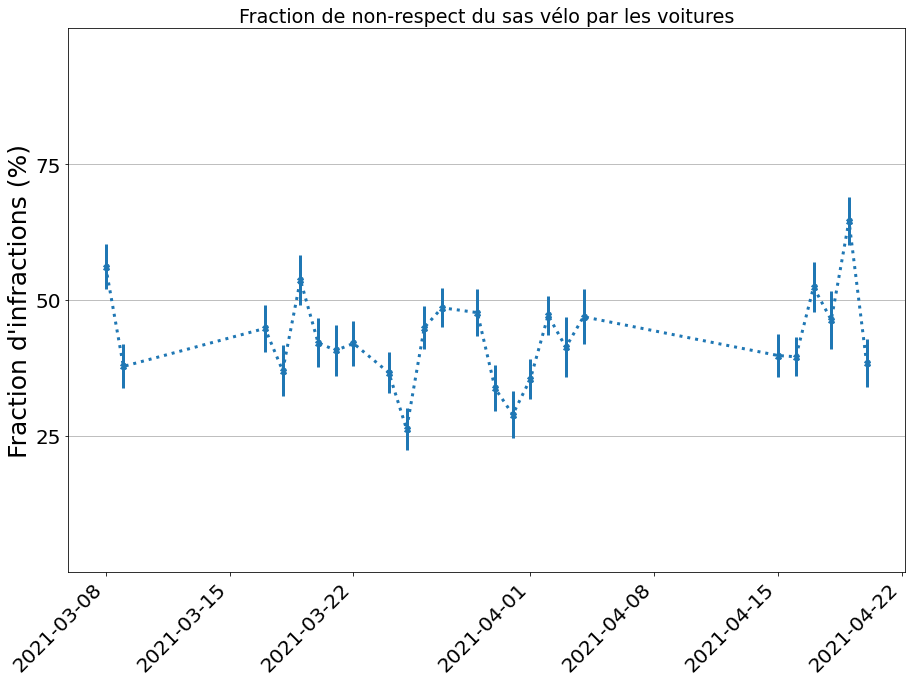

In [15]:
plt.figure(figsize=(15,10))
plt.errorbar(df_full['date'], 100 * df_full['best_fit_ratio'],
             yerr=100*df_full['error'], marker='X', linestyle=':')
plt.ylim(0,100)
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.yticks([25,50,75])
plt.ylabel('Fraction d\'infractions (%)')
plt.title('Fraction de non-respect du sas vélo par les voitures');

In [22]:
import bokeh
from bokeh.models.tools import HoverTool
from bokeh.plotting import figure, show

bokeh.io.output_notebook()

data = bokeh.models.ColumnDataSource({
    'n_pic':      df_full['nocar']+df_full['respect']+df_full['infraction'],
    'n_car':      df_full['respect']+df_full['infraction'],
    'date':       df_full['date'],
    'best_fit_ratio':      100*df_full['best_fit_ratio'],
    'error_up': 100*(df_full['best_fit_ratio']+df_full['error']),
    'error_low': 100*(df_full['best_fit_ratio']-df_full['error'])
})

p = figure(
    #y_range=(0, 10),
    toolbar_location=None,
    sizing_mode="stretch_width",
    max_width=800,
    plot_height=500,
    x_axis_type='datetime',
    y_range=(0,100)
)

# add renderers
p.line(x='date', y='best_fit_ratio', source=data, line_width=2, line_color='black', line_dash='dashed')
p.circle(x='date', y='best_fit_ratio', size=10, source=data, line_color='black', fill_color='black')

# add uncertainties
p.add_layout(
    bokeh.models.Whisker(source=data, base='date', upper='error_up', lower='error_low')
)

# change grid
half = bokeh.models.Span(location=50,
              dimension='width', line_color='red',
              line_dash='dashed', line_width=3)
p.add_layout(half)
p.ygrid.band_fill_color = "olive"
p.ygrid.band_fill_alpha = 0.1
p.yaxis.axis_label = 'Fraction d\'infractions (%)'

# Add tooltips
p.add_tools(bokeh.models.HoverTool(
    tooltips = [
        ('Nombre de voitures', '@n_car'),
        ('Nombre de cycles de feu', '@n_pic'),
    ],
    mode = 'mouse',
))

p.toolbar_location = "below"

# show the results
show(p)

Loading BokehJS ...

## Infraction ratio per weekday

In [17]:
df_weekday['day_of_week'] = df_weekday['date'].apply(lambda x: x.weekday()) # get the weekday index, between 0 and 6
df_weekday['day_of_week'] = df_weekday['day_of_week'].apply(lambda x: calendar.day_name[x])
df_weekday = df_weekday.groupby('day_of_week').sum()

df_weekday['day_id'] = df_weekday.index
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
df_weekday['day_id'] = df_weekday['day_id'].map(sorterIndex)

df_weekday.sort_values(by='day_id', inplace=True)

df_weekday

,nocar,respect,infraction,day_id
day_of_week,,,,
Monday,1382,360,398,0
Tuesday,909,336,217,1
Wednesday,1139,347,229,2
Thursday,1632,501,305,3
Friday,1431,486,429,4
Saturday,1122,368,338,5
Sunday,1385,231,200,6


In [18]:
best_fit = []
error = []

for i in range(df_weekday.shape[0]):
    n = (df_weekday.iloc[i]['nocar'], df_weekday.iloc[i]['respect'], df_weekday.iloc[i]['infraction'])
    m = Minuit(multinomial(n, conf_matrix_nom), p2=n[2]/np.sum(n), r=n[2]/np.sum(n[1:]))
    m.errordef = 0.5
    m.migrad()
    best_fit.append( m.values['r'] )
    error.append( m.errors['r'] )
    
df_weekday['best_fit_ratio'] = best_fit
df_weekday['error'] = error

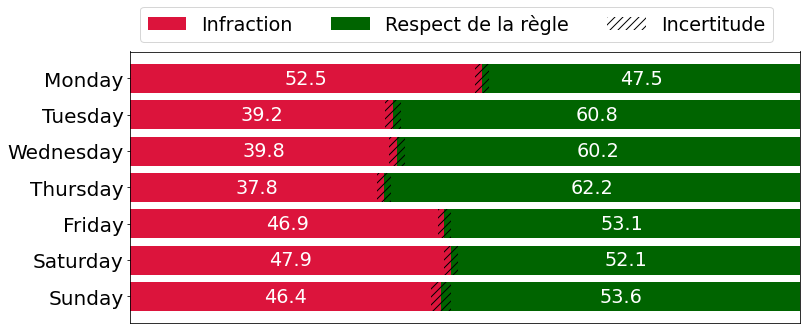

In [21]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 100)

infraction_ratio = 100 * df_weekday.infraction / (df_weekday.infraction+df_weekday.respect)
error = 100 * df_weekday.error
respect_ratio = 100 * df_weekday.respect / (df_weekday.infraction+df_weekday.respect)
ax.barh(df_weekday.index, infraction_ratio, color='crimson', label='Infraction')
ax.barh(df_weekday.index, respect_ratio, left=infraction_ratio, color='darkgreen', label='Respect de la règle')
ax.barh(df_weekday.index, error, left=infraction_ratio-error/2, color='white', hatch='///', label='Incertitude', alpha=0)
plt.rcParams['hatch.color'] = 'black'

for i in range(df_weekday.shape[0]):
    ax.text(infraction_ratio[i]/2, i, f'{infraction_ratio[i]:.1f}',
            color='white', ha='center', va='center', fontsize='large')
    ax.text(infraction_ratio[i] + respect_ratio[i]/2, i, f'{respect_ratio[i]:.1f}',
            color='white', ha='center', va='center', fontsize='large')
    
ax.legend(ncol=3, bbox_to_anchor=(0, 1), loc='lower left', fontsize='large');

fig.savefig('infraction_day.png', bbox_inches='tight')

## Cross-check accuracy

In [35]:
np.where(np.array(pred_labels[-3])==1)

(array([  1,   3,   6,  10,  11,  13,  17,  19,  23,  39,  46,  49,  51,
         53,  55,  58,  62,  64,  68,  69,  78,  80,  84,  88,  90,  91,
         96,  98, 100, 108, 110, 111, 113, 117, 120, 121, 122, 124, 127,
        128, 130, 132, 138, 139, 143, 145, 149, 152, 154, 158, 160, 189,
        190, 199, 202, 205, 214, 227, 229, 243, 247, 250, 262, 265, 269,
        272, 280, 283, 290, 295, 296, 298, 322, 331, 335, 338, 346, 348,
        353, 358, 359, 372, 383, 393, 394, 396, 406, 408, 415, 426, 432,
        433, 434, 437, 451, 452, 455, 456, 466, 469, 480, 498, 502, 509,
        516, 517, 523, 545, 563]),)

In [36]:
labels = getLabels('input/2021-03-25/')
np.sum(np.array(pred_labels[9]) != labels) / len(labels)

0.027552674230145867

In [37]:
counts_list[9]

array([425, 133,  59])

In [3]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/theo/.config/matplotlib/matplotlibrc'